In [3]:
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoImageProcessor, ViTModel
from PIL import Image
import requests
import torch
import os
import math
from torchvision.transforms import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [31]:
cache_dir="E:\work\CCTech\Experiments\LLMs\ModelCard"
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir=cache_dir)
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir=cache_dir)

In [32]:
product_cropped_dir = f"../data/product_detection_from_packshots/product_masked_images"
product_path_list = [f"{product_cropped_dir}/{file_name}" for file_name in os.listdir(product_cropped_dir)]
shelf_dir = f"../data/product_detection_from_packshots/shelf_cropped_masks_images"
shelf_path_list = [f"{shelf_dir}/{file_name}" for file_name in os.listdir(shelf_dir)]
shelf_annot_dir = f"../data/product_detection_from_packshots/shelf_masks"

In [74]:
def similarity_plot(img1, img2, similarity_score):
    # Create a figure with two subplots
    #fig, axes = plt.subplots(1, 2, gridspec_kw={'height_ratios': [2], 'hspace': 2})
    fig, axes = plt.subplots(1, 2)
    # Display the first image
    axes[0].imshow(img1)
    axes[0].set_title('Product Image')

    # Display the second image
    axes[1].imshow(img2)
    axes[1].set_title('On Shelf Product Image')

    # Set the title for the entire figure
    fig.suptitle(f'Similarity Score: {similarity_score[0]*100:0.2f} %', y=1.05, fontsize=14)

    # Adjust the spacing between subplots
    #plt.subplots_adjust(top=1, bottom=0.1, wspace=0.15)
    plt.subplots_adjust(top=0.85, bottom=0.15, wspace=0.4)

    # Show the figure
    plt.show()

def similarity(image_path1, image_path2, resize=False):
    #Correct Comparision
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    product_image = Image.open(image_path1)
    if resize: 
        #resize image by 10 time, as product image is high res as compared to shelf product images
        product_image = product_image.resize((product_image.size[0]//10, product_image.size[1]//10))
    product_input = image_processor(product_image, return_tensors="pt")

    shelf_product_image = Image.open(image_path2)
    shelf_product_input = image_processor(shelf_product_image, return_tensors="pt")

    with torch.no_grad():
        out1 = model(**shelf_product_input)
    last_hidden_states1 = torch.reshape(out1.last_hidden_state, (1,-1))

    with torch.no_grad():
        out2 = model(**product_input)
    last_hidden_states2 = torch.reshape(out2.last_hidden_state, (1,-1))

    similarity_score = cos(last_hidden_states1, last_hidden_states2)
    print(f"Similarity Score: {similarity_score[0]*100:0.2f} %")

    similarity_plot(product_image, shelf_product_image, similarity_score)

    


Similarity Score: 4.23 %


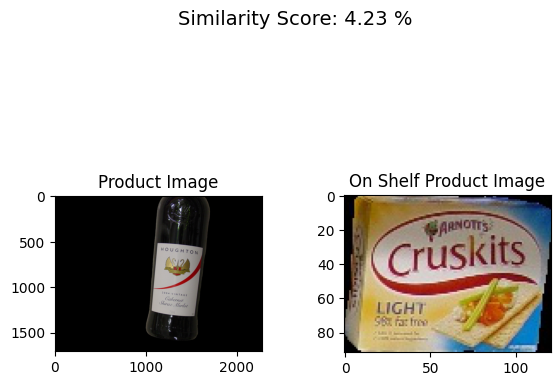

In [75]:
product_path = "../data/product_detection_from_packshots/product_masked_images/qr1.jpg"
shelf_product_path = "../data/product_detection_from_packshots/shelf_cropped_masks_images/db1195/3.jpg"
similarity(product_path, shelf_product_path, resize=False)

Similarity Score: 31.78 %


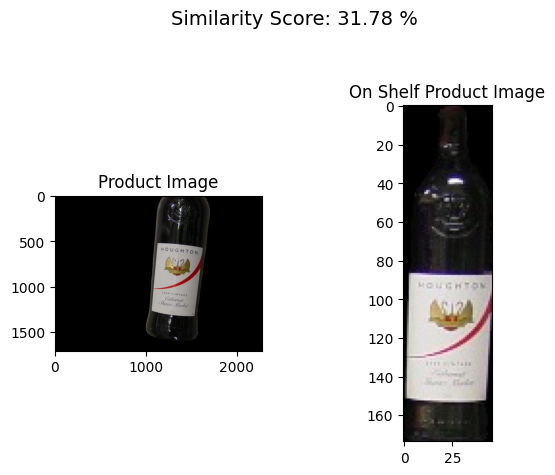

In [76]:
product_path = "../data/product_detection_from_packshots/product_masked_images/qr1.jpg"
shelf_product_path = "../data/product_detection_from_packshots/shelf_cropped_masks_images/db932/58.jpg"
similarity(product_path, shelf_product_path, resize=False)

Similarit Score: tensor([0.0423])


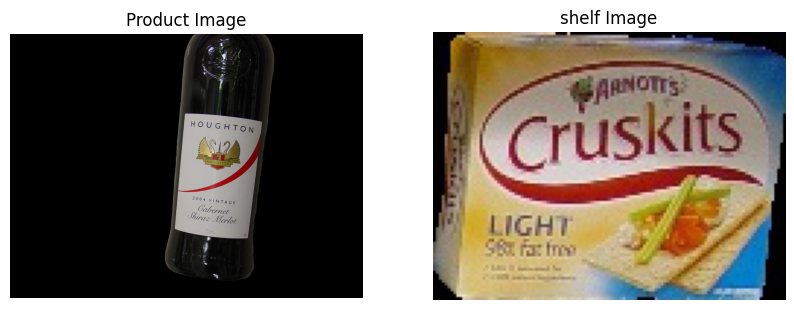

In [37]:
def infer():
    product_n = len(product_path_list)
    product_counter = 0
    for product_path in product_path_list:
        img1 = Image.open(product_path)
        with torch.no_grad():
            inp1 = image_processor(img1, return_tensors="pt")
            out1 = model(**inp1)
        last_hidden_states1 = torch.reshape(out1.last_hidden_state, (1,-1))
        shelf_n = len(shelf_path_list)
        shelf_counter = 0
        for shelf_path in shelf_path_list:
            obj_path_list = [f"{shelf_path}/{file_name}" for file_name in os.listdir(shelf_path)]
            obj_n = len(obj_path_list)
            obj_counter = 0
            for obj_path in obj_path_list:
                shelf_name = obj_path.split("/")[-2]
                bbox_counter = obj_path.split("/")[-1].split(".")[0]
                bbox_path = f"{shelf_annot_dir}/{shelf_name}/bbox_{bbox_counter}.npy"
                img2 = Image.open(obj_path)
                with torch.no_grad():
                    inp2 = image_processor(img2, return_tensors="pt")
                    out2 = model(**inp2)
                

                np_bbox = np.load(bbox_path)
                x, y, w, h = np_bbox[0], np_bbox[1], np_bbox[2], np_bbox[3]
                
                print(img1.size, img2.size, x, y, w, h)

                obj_counter+=1
                break
            shelf_counter+=1
            break
        product_counter += 1
        break
infer()

(2272, 1704) (55, 45) 518 514 55 45
